# **Feminicide on Reddit:  how is it perceived?**

Cervini Stella\
Montalbano Daniel\
Sabino Giuseppe

**Femicide** describes the deliberate killing of women or girls because of their gender, often stemming from societal factors like misogyny or gender-based violence. Only in Italy, in 2023, **43 women were killed** and, unformately, their death's circumstances fall under this definition.

*Sources*:

https://femminicidioitalia.info/lista/2023

https://www.la7.it/fa-che-io-sia-lultima/video/violenza-sulle-donne-103-femminicidi-in-italia-nel-2023-le-identita-e-le-storie-delle-vittime-24-11-2023-515513

In this project, we try to gather information about **how people perceived these deaths** and if there where **any reaction online**. We will also try to find out correlation wuth related topics, such as *Gender Violence, Feminism and Patriarchy*.\
We will give particular importance to the case of Giulia Cecchettin, which is the one that obtained the most media exposure.\
For this matter, we will consider data from **Reddit**.

**IMPOTANT NOTES ON THE PROJECT**\
In order to the project to run smoothly it is **fundamental** to dowload and import in your own Drive the following folder:
https://drive.google.com/drive/folders/18bAunz1nKGR75ALbDDQ-xRgL-A7DxOei?usp=sharing \

Also, in order to collect data from Reddit, we make use of the library `praw`, which is the python Reddit API Wrapper that allows for simple access to Reddit's API. A *JSON file with cretentials* for a developer account must be provided (stored on your own Drive).



## **Packages installing and import**

In [ ]:
!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install Cython

In [ ]:
import praw
import requests
import pandas as pd
import json
import os
from datetime import datetime
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import plotly.graph_objects as go
import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import seaborn as sns
import matplotlib.dates as mdates
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('italian'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Data collection**



In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# retrieve credentials
with open("/content/drive/MyDrive/redditCredentials.json", "r") as f:
    credentials = json.load(f)

In [ ]:
# open connection with Reddit API
reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='Tutorial by /user/SMA202324',
                     username=credentials['USERNAME'],
                     check_for_async=False)

In [ ]:
keywords = ['Filippo Turetta', 'Giulia Cecchettin', 'Femminismo', '25 novembre', 'Patriarcato', 'Femminicidio', 'Violenza']

In [ ]:
# the goal is the create a dictionary filled with all the data
outside_dictionary = {}
for keyword in keywords:
  #inside_dictionary = {}
  temp_list = []
  for submission in reddit.subreddit("italia").search(keyword, limit=1000):
      submission_data = { # this is already a dictionary --> we just need to put them all  together
          'author': '',
          'comments': submission.comments,
          'created_utc': submission.created_utc,
          'id': submission.id,
          'num_comments': submission.num_comments,
          'score': submission.score,
          'title': submission.title,
          'upvote_ratio': submission.upvote_ratio
      }
      try:
        submission_data['author'] = submission.author
      except AttributeError:
        pass
      submission.comments.replace_more(limit=0)
      temp_list.append(submission_data)
      #print(len(temp_list))
  outside_dictionary[keyword] = temp_list

## **Data manipulation**
Thanks to the code above, we have retrieved all the posts we are interested in and each of them is stored in a separate list. In order to analyze the data, the first thing we do is transform these lists in **dataframes**.

In [ ]:
df_violenza = pd.DataFrame(outside_dictionary['Violenza'])
df_cecchettin = pd.DataFrame(outside_dictionary['Giulia Cecchettin'])
df_turetta = pd.DataFrame(outside_dictionary['Filippo Turetta'])
df_femminicidio = pd.DataFrame(outside_dictionary['Femminicidio'])
df_femminismo = pd.DataFrame(outside_dictionary['Femminismo'])
df_patriarcato = pd.DataFrame(outside_dictionary['Patriarcato'])
df_novembre = pd.DataFrame(outside_dictionary['25 novembre'])

In [ ]:
# total number of entries
print(df_violenza.shape[0] + df_cecchettin.shape[0] + df_turetta.shape[0] + df_femminicidio.shape[0] + df_femminismo.shape[0] + df_patriarcato.shape[0] + df_novembre.shape[0])

421


From here, we divide all the data in **two dataframes**:

*   the **first one** regarding the case of **Giulia and Filippo**;
*   The **second one** regarding all the **other subjects** we found relevant in this context.

They will be analysed separately.

In [ ]:
df_omicidio = pd.concat([df_cecchettin, df_turetta], ignore_index=True)
df_parole = pd.concat([df_violenza, df_femminicidio, df_femminismo, df_patriarcato, df_novembre], ignore_index=True)

In [ ]:
# get posting date
df_omicidio['created_utc'] = df_omicidio['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
df_parole['created_utc'] = df_parole['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
# order dataframe by posting date
df_omicidio= df_omicidio.sort_values(by=['created_utc']).reset_index(drop=True)
df_parole= df_parole.sort_values(by=['created_utc']).reset_index(drop=True)

In [ ]:
type(df_violenza.comments)

pandas.core.series.Series

In [ ]:
# reshape the dataframes
list_of_dict=[]
for i in range(0,len(df_omicidio)-1):
  comments= df_omicidio['comments'].iloc[i]
  for comment in comments:
    c= {}
    c['title']=df_omicidio['title'].iloc[i]
    c['comments']=comment.body
    c['id_commento']=i
    c['response']=False
    c['created_utc'] = comment.created_utc
    # here I added more fields needed later > Content analysis > Exploratory analyis
    c['num_comments'] = df_omicidio['num_comments'].iloc[i]
    c['upvote_ratio'] = df_omicidio['upvote_ratio'].iloc[i]
    c['score'] = df_omicidio['score'].iloc[i]
    list_of_dict.append(c)
    for comment in comments:
      replies = comment.replies
      for r in replies:
         c= {}
         c['title']=comment.body
         c['comments']=r.body
         c['id_commento']=i
         c['response']=True
         c['created_utc']=r.created_utc
         ### NOT SURE IF THIS IS CORRECT
         c['num_comments'] = df_omicidio['num_comments'].iloc[i]
         c['upvote_ratio'] = df_omicidio['upvote_ratio'].iloc[i]
         c['score'] = df_omicidio['score'].iloc[i]
         list_of_dict.append(c)


df_comment_omicidio = pd.DataFrame(list_of_dict)
df_comment_omicidio['created_utc'] = df_comment_omicidio['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
df_comment_omicidio= df_comment_omicidio.sort_values(by=['created_utc']).reset_index(drop=True)
df_comment_omicidio = df_comment_omicidio.drop_duplicates(subset=['comments']).reset_index(drop=True)
df_comment_omicidio

,title,comments,id_commento,response,created_utc,num_comments,upvote_ratio,score
0,"Venezia, la 22enne Giulia Cecchettin e l'ex fi...",E' come leggere un libro appena iniziato conos...,0,False,2023-11-13 17:19:17,111,0.97,62
1,"Venezia, la 22enne Giulia Cecchettin e l'ex fi...",Ahia,0,False,2023-11-13 17:44:31,111,0.97,62
2,E' come leggere un libro appena iniziato conos...,Fuga d’amore?,1,True,2023-11-13 17:44:59,111,0.97,63
3,"Venezia, la 22enne Giulia Cecchettin e l'ex fi...","la tiro a caso, lui cerca di convincerla a tor...",1,False,2023-11-13 18:13:53,111,0.97,63
4,"Venezia, la 22enne Giulia Cecchettin e l'ex fi...",Un amore tagliato a fette,0,False,2023-11-13 18:25:59,111,0.97,62
...,...,...,...,...,...,...,...,...
1998,Perché Giulia è diventata un simbolo del femmi...,Zio calmati e rivaluta le tue aspettative su r...,32,True,2024-01-11 14:02:50,51,0.24,0
1999,RAL?,Hahahah,32,True,2024-01-11 19:11:07,51,0.24,0
2000,Ho una domanda,Perché all’occidente non gliene frega niente d...,32,False,2024-01-11 20:42:28,51,0.24,0
2001,Quelli che rispondono non ironicamente sono pe...,Ma che minchia di commento è? Se questo è vera...,32,True,2024-01-12 14:25:37,51,0.24,0


In [ ]:
list_of_dict=[]
for i in range(0,len(df_parole)-1):
  comments= df_parole['comments'].iloc[i]
  for comment in comments:
    c= {}
    c['title']=df_parole['title'].iloc[i]
    c['comments']=comment.body
    c['id_commento']=i
    c['response']=False
    c['created_utc']=comment.created_utc
    c['num_comments'] = df_parole['num_comments'].iloc[i]
    c['upvote_ratio'] = df_parole['upvote_ratio'].iloc[i]
    c['score'] = df_parole['score'].iloc[i]
    list_of_dict.append(c)
    for comment in comments:
      replies = comment.replies
      for r in replies:
         c= {}
         c['title']=comment.body
         c['comments']=r.body
         c['id_commento']=i
         c['response']=True
         c['created_utc']=r.created_utc
         c['num_comments'] = df_parole['num_comments'].iloc[i]
         c['upvote_ratio'] = df_parole['upvote_ratio'].iloc[i]
         c['score'] = df_parole['score'].iloc[i]
         list_of_dict.append(c)

df_comment_parole = pd.DataFrame(list_of_dict)
df_comment_parole['created_utc'] = df_comment_parole['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
df_comment_parole= df_comment_parole.sort_values(by=['created_utc']).reset_index(drop=True)
df_comment_parole = df_comment_parole.drop_duplicates(subset=['comments']).reset_index(drop=True)
df_comment_parole

,title,comments,id_commento,response,created_utc,num_comments,upvote_ratio,score
0,"Processo Vatileaks, Francesca Chaoqui e l'Ital...",Ammazza che bel post che hai scritto! Questa f...,0,False,2016-03-18 10:04:48,3,1.00,4
1,Ammazza che bel post che hai scritto! Questa f...,> il rapporto tra i due fratelli \n\nIl presti...,0,True,2016-03-18 10:10:22,3,1.00,4
2,"Processo Vatileaks, Francesca Chaoqui e l'Ital...","I'm a bot, *bleep*, *bloop*. Someone has linke...",0,False,2016-03-18 12:23:50,3,1.00,4
3,Reato di negazionismo: penalisti e storici fer...,"I'm a bot, *bleep*, *bloop*. Someone has linke...",3,False,2016-06-09 10:41:49,2,0.72,3
4,Reato di negazionismo: penalisti e storici fer...,Il [documento del Senato](http://www.senato.it...,3,False,2016-06-09 11:12:27,2,0.72,3
...,...,...,...,...,...,...,...,...
15583,"Ciao ragazzi, sono un ragazzo 15 enne, vorrei ...","Come sfruttare un tema delicato, attuale e cal...",385,False,2024-01-11 12:04:49,22,0.13,0
15584,"Come sfruttare un tema delicato, attuale e cal...","In realtà mi è stato commissionato come ""lavor...",385,True,2024-01-11 14:07:50,22,0.13,0
15585,"Come sfruttare un tema delicato, attuale e cal...",Appunto come hai detto tu ( perchè hai ragione...,384,True,2024-01-11 14:10:59,22,0.07,0
15586,"Ciao ragazzi, sono un ragazzo 15 enne, vorrei ...",Perche' non vai contro la massa e fai un podca...,384,False,2024-01-11 15:33:50,22,0.07,0


The columns `title` is the title from the thred if the post is the one originating the conversation, while if the post is a reply to another post, then `title` is the original post. In this way, we are able to create a the history for each post.

## **Network analysis**
**Network analysis** on social media involves studying the connections and relationships between individuals or entities within a social network. It's a method used to analyze how people or elements are interconnected, how information flows, and how communities form and interact on social media platforms.

Here we will perfom **Community Detection** and focus on which topics each community is interested in.

**Community detection** in the context of social network analysis refers to the process of identifying clusters or groups of nodes (individuals, accounts, entities) within a network that exhibit higher connectivity among themselves compared to the rest of the network. These clusters are considered as "communities" or "modules."

The goal of community detection is to unveil the underlying structure of the network by **identifying these cohesive groups**. Algorithms used for community detection aim to maximize intra-group connections (intra-community edges) and minimize inter-group connections (inter-community edges).



### **Comments network**

In the pursuit of a granular understanding of online community dynamics, we devised a network architecture aimed at elucidating the intricate relationships between post authors and comment contributors.

The overarching objective of this network construction was to systematically connect the originators of posts with every individual engaging in discussions through comments

For each post contained in df_parole we store inside d the author of the post together with any author of every comment of the post

In reddit exists the chance to post a comment anonimously, so there are some cases whom the author is None, so we don't store that connection.

In [ ]:
d= []
first_level_comments = []
if not os.path.exists(f"/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/network_comments_final_2.csv"):
  for index, i in df_parole.iterrows():
    sub_auth= i['author']
    sub= reddit.submission(i['id'])
    sub.comments.replace_more(limit=None)
    for top_level_comment in sub.comments:
      top_l_auth= top_level_comment.author
      elem= []
      if top_l_auth != None:
        first_level_comments.append({
            "comment":top_level_comment.body,
            "author": str(top_l_auth)
        })
        print(f"sub: {sub_auth}")
        print(f"top: {top_l_auth}")
        elem.append(str(sub_auth))
        elem.append(str(top_l_auth))
        d.append(elem)
else:
  d_path = '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/network_comments_final_2.csv'
  d = pd.read_csv(d_path)


In [ ]:
# d= []
# first_level_comments = []
# for index, i in df_parole.iterrows():
#     sub_auth= i['author']
#     sub= reddit.submission(i['id'])
#     sub.comments.replace_more(limit=None)
#     for top_level_comment in sub.comments:
#       top_l_auth= top_level_comment.author
#       elem= []
#       if top_l_auth != None:
#         first_level_comments.append({
#             "comment":top_level_comment.body,
#             "author": str(top_l_auth)
#         })
#         print(f"sub: {sub_auth}")
#         print(f"top: {top_l_auth}")
#         elem.append(str(sub_auth))
#         elem.append(str(top_l_auth))
#         d.append(elem)

In [ ]:
len(d)

9957

In [ ]:
# len(first_level_comments)

In [ ]:
# pd.DataFrame(d,columns=['Author1','Author2']).to_csv('/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/network_comments_final_2.csv', index=False)

In [ ]:
# pd.DataFrame(first_level_comments,columns=['comment','author']).to_csv('/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/content_comments_final_2.csv', index=False)

We obtained a list of 5511 couple of post author and comment author.

In [ ]:
g_df= pd.DataFrame(d,columns=['Author1','Author2'])

In [ ]:
g_df= g_df.drop_duplicates()

In [ ]:
len(g_df)

8276

### Graph Creation

We deleted duplicates that exist when a user has several comments in some unique author's post and now we have 5031 couples and we can create the graph adding one edge for eache couple of authors(nodes) in our dataframe g_df.

In [ ]:
G= nx.Graph()
for index, r in g_df.iterrows():
  G.add_edge(r['Author1'],r['Author2'])

### Graph Cleaning
We remove nodes with 0 degree from the graph and also nodes that are returned from the networkx funzion isolates(G)

In [ ]:
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(isolated_nodes)

In [ ]:
isolated_pairs = list(nx.isolates(G))
G.remove_nodes_from(isolated_pairs)

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")

Number of Nodes: 4770
Number of Edges: 8273


After removing some nodes, we have 3301 nodes and 5030 edges

### Graph Visualization
This is our graph plotted, we have some nodes outside the main component of the graph and we decided to remove it in order to achive better results and more clear analysis.

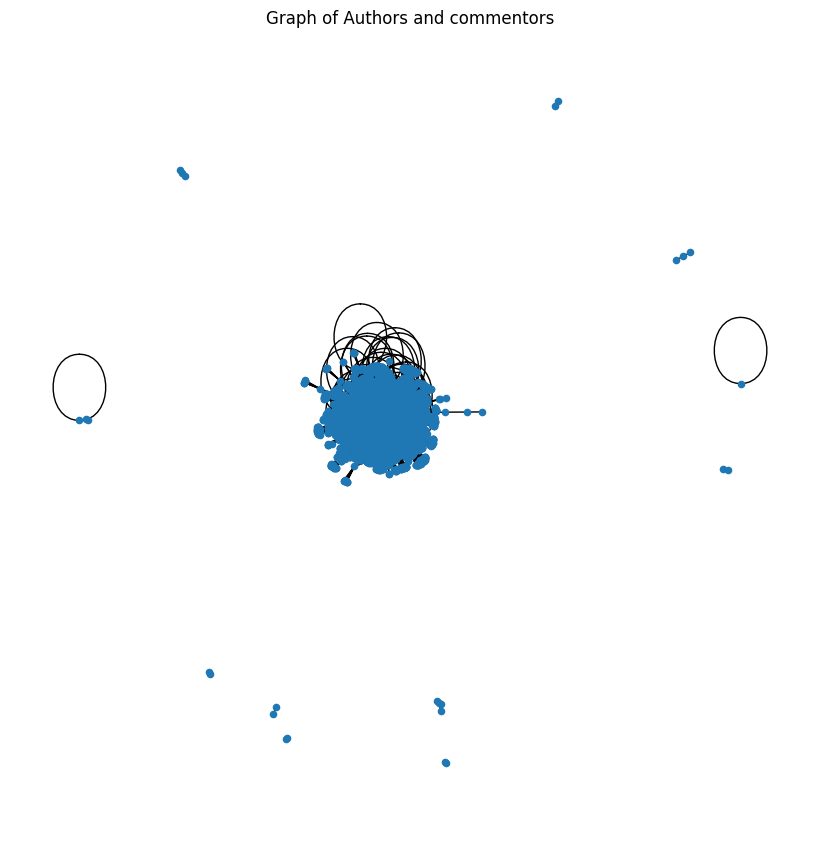

In [ ]:
plt.figure(figsize=(8,8))
nx.draw_spring(G, node_size=20, with_labels=False)
plt.title('Graph of Authors and commentors')
plt.show()

### Giant Component Analysis

In order to remove the outsider nodes, we try to visualize the giant component and make some considerations about it:

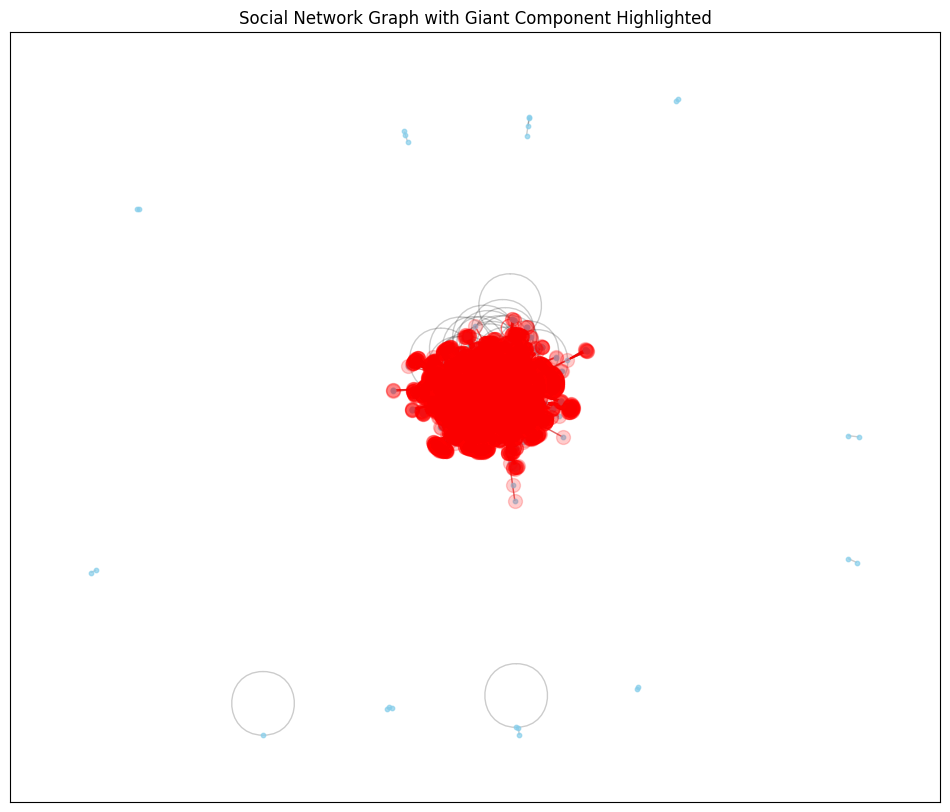

In [ ]:
components = list(nx.connected_components(G))

# Find the giant component (largest connected component)
giant_component = max(components, key=len)

# Create a subgraph containing only the giant component
giant_component_subgraph = G.subgraph(giant_component)

# Draw the entire graph with the giant component highlighted
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 10))

# Draw nodes and edges for the entire graph
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Draw nodes and edges for the giant component with a different color
nx.draw_networkx_nodes(giant_component_subgraph, pos, node_size=100, node_color='red', alpha=0.2)
nx.draw_networkx_edges(giant_component_subgraph, pos, alpha=0.5, edge_color='red')

#nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Social Network Graph with Giant Component Highlighted')
plt.show()

As we can see, the nodes are almost all concentrated inside the giant component, so we decided to remove from the graph all the nodes that aren't part of the giant component:

In [ ]:
G.remove_nodes_from(set(G.nodes) - set(giant_component))

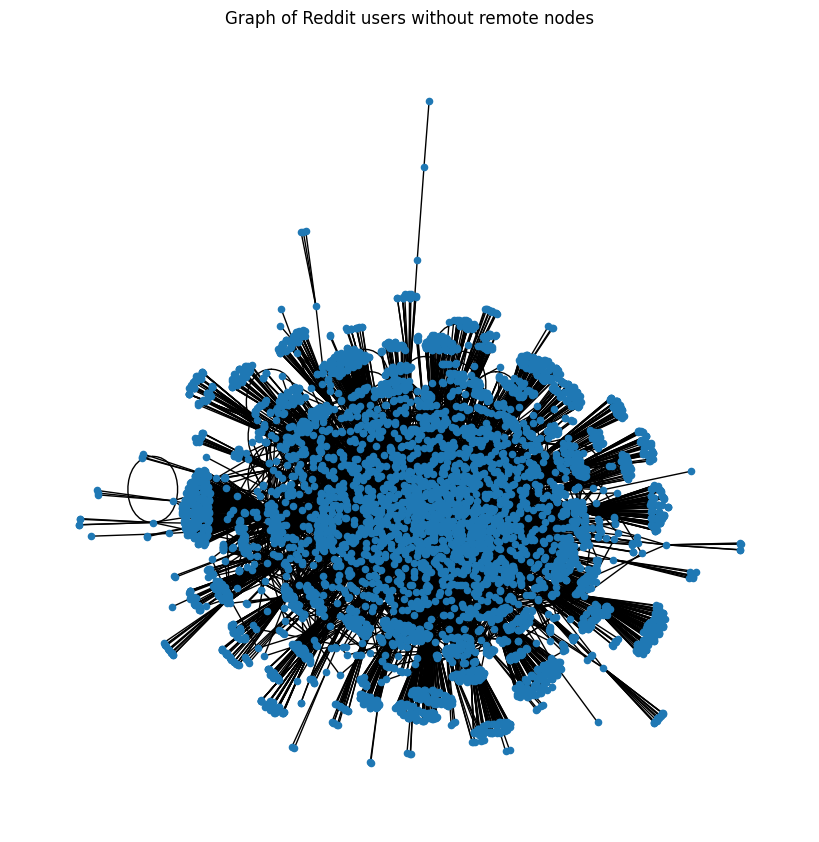

In [ ]:
plt.figure(figsize=(8,8))
nx.draw_spring(G, node_size=20, with_labels=False)
plt.title('Graph of Reddit users without remote nodes')
plt.show()

As we can see in this visualization we obtained a more concentrated and dense graph, so we can start analyzing the network.

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")

Number of Nodes: 4744
Number of Edges: 8256


After the remotion of the remote nodes we have a graph made of 3275 nodes and 5013 edges

#### **Metrics**


### Average degree



In [ ]:
avg_degree = sum(dict(G.degree()).values()) / num_nodes

print(f"Average Degree: {avg_degree}")

Average Degree: 3.480607082630691


This value represents the average degree of nodes in the graph. The degree of a node is the number of edges connected to it. In this case, the average degree across all nodes in the graph is approximately 3.04. Higher average degrees suggest a more interconnected graph, while lower values may indicate a sparser network. Analyzing the distribution of node degrees can further enhance our understanding of the structural characteristics of the network.

### Density

In [ ]:
density = nx.density(G)

print(f"Density: {density}")

Density: 0.0007338408354692582


The density of a graph is a measure of how many edges are present compared to the total number of possible edges. It ranges from 0 (sparse graph) to 1 (dense graph). In this case, the density is approximately 0.00094, indicating a relatively sparse graph.

### Average Clustering

In [ ]:
avg_clustering = nx.average_clustering(G)

print(f"Average Clustering: {avg_clustering}")

Average Clustering: 0.01784601277395068


The average clustering coefficient measures the tendency of nodes to form clusters or groups. It ranges from 0 to 1, where higher values indicate a higher tendency for nodes to form tightly-knit groups. In this case, the average clustering coefficient is approximately 0.018, suggesting a relatively low level of clustering in the graph.

### Radius

In [ ]:
radius = nx.radius(G)

print("Radius:", radius)

Radius: 5


The radius of a graph is the minimum eccentricity among all nodes. It represents the minimum distance from the farthest node to any other node in the graph. In this case, the radius is 5, indicating that the minimum distance from any node to its farthest neighbor is 5.

### Diameter

In [ ]:
diameter = nx.diameter(G)
print("Diameter:", diameter)

Diameter: 9


The diameter of a graph is the maximum eccentricity among all nodes. It represents the longest shortest path between any two nodes in the graph. In this case, the diameter is 8, indicating that the longest shortest path between any two nodes in the graph is of length 8.

### Degree Centrality

Degree centrality values provide information about the relative importance of nodes based on their connectivity in the graph. Higher values indicate nodes with more connections, suggesting a greater influence or centrality in the network. These are the top 10 nodes by degree centrality of the graph:

In [ ]:
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality in descending order
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 nodes
for i, (username, centrality) in enumerate(sorted_nodes[:10]):
    print(f"{i+1}. {username}: Degree Centrality = {centrality}")

1. notsostrong134: Degree Centrality = 0.08328062407758802
2. SmellyFatCock: Degree Centrality = 0.04828167826270293
3. Syzygy82: Degree Centrality = 0.04596247100990934
4. DurangoGango: Degree Centrality = 0.040059034366434744
5. ffioca: Degree Centrality = 0.03183639047016656
6. MrShinzen: Degree Centrality = 0.031203879401222854
7. Pure-Contact7322: Degree Centrality = 0.030149694286316676
8. WrongQuesti0n: Degree Centrality = 0.029728020240354206
9. Single-Brain-1235: Degree Centrality = 0.028884672148429262
10. Puzzleheaded-Cat2852: Degree Centrality = 0.02867383512544803


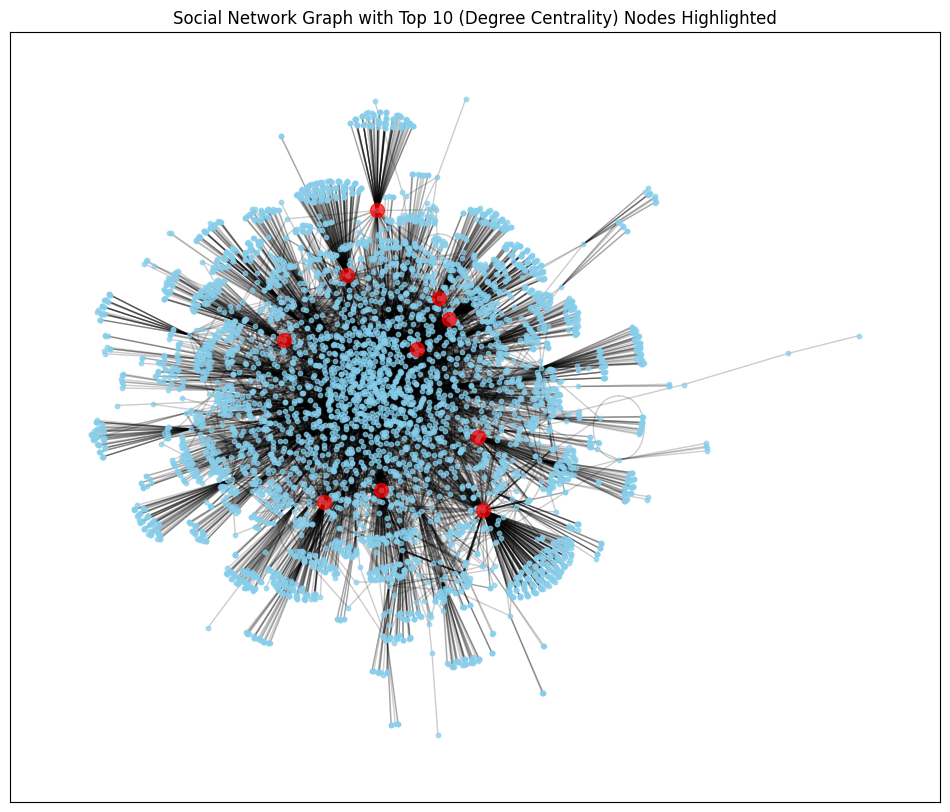

In [ ]:
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 10))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Get the top 10 nodes
top_nodes = [node for node, _ in sorted_nodes[:10]]

# Draw important nodes with a different color
nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_size=100, node_color='red', alpha=0.7)

plt.title('Social Network Graph with Top 10 (Degree Centrality) Nodes Highlighted')
plt.show()

### Eigenvector Centrality

Eigenvector centrality values reflect the importance of nodes in a graph based on both their direct connections and the connections of their neighbors. Higher eigenvector centrality values signify nodes with influential connections, indicating a greater overall influence or centrality within the network. These are the top 10 nodes with the highest eigenvector centrality in the graph:

Top 10 Nodes by Eigenvector Centrality:
notsostrong134: Eigenvector Centrality = 0.5225518230840952
DurangoGango: Eigenvector Centrality = 0.1799786321080025
Pure-Contact7322: Eigenvector Centrality = 0.1710616930416018
SmellyFatCock: Eigenvector Centrality = 0.14902791494275106
Syzygy82: Eigenvector Centrality = 0.13704947351496632
MrShinzen: Eigenvector Centrality = 0.10877455114059921
Eugenio_Prigozzi: Eigenvector Centrality = 0.09622227390403998
Kernel_Paniq: Eigenvector Centrality = 0.0874358955264681
RiccardoForni: Eigenvector Centrality = 0.08692493869591363
ftrx: Eigenvector Centrality = 0.08581098294194822


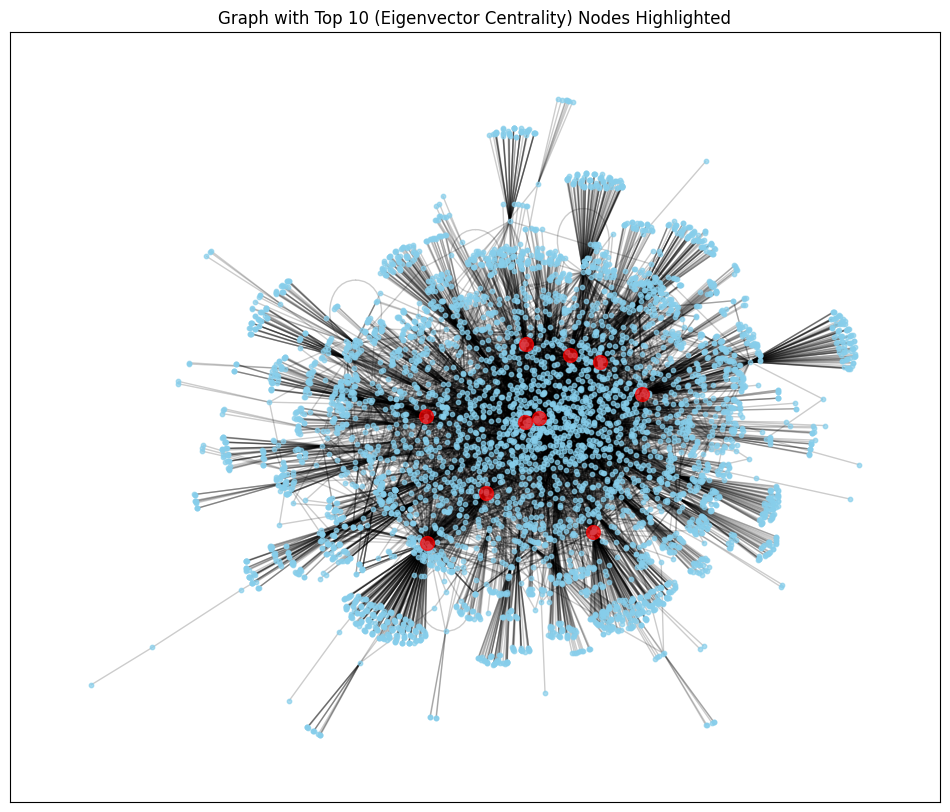

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G)

# Get the top nodes by eigenvector centrality
top_eigenvector_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:10]

# Print eigenvector centrality for each of the top nodes
print("Top 10 Nodes by Eigenvector Centrality:")
for username in top_eigenvector_nodes:
    centrality = eigenvector_centrality[username]
    print(f"{username}: Eigenvector Centrality = {centrality}")

# Plot the graph with the top nodes highlighted
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 10))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Get the top nodes
top_nodes = [node for node in top_eigenvector_nodes]

# Draw important nodes with a different color
nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_size=100, node_color='red', alpha=0.7)

plt.title('Graph with Top 10 (Eigenvector Centrality) Nodes Highlighted')
plt.show()

### Betweennes and Closeness Centrality

Betweenness Centrality identifies nodes that act as critical bridges between different parts of the graph. Higher betweenness centrality values suggest nodes that play a crucial role in facilitating communication and connectivity between other nodes.

Closeness Centrality assesses how quickly a node can reach other nodes in the graph. Higher closeness centrality values indicate nodes that are centrally located and can efficiently interact with other nodes.



notsostrong134: Betweenness Centrality = 0.13607816848285562, Closeness Centrality = 0.35605435027400345
DurangoGango: Betweenness Centrality = 0.07501112372558476, Closeness Centrality = 0.3697957274286605
Pure-Contact7322: Betweenness Centrality = 0.07485859741225795, Closeness Centrality = 0.37538583300356154
SmellyFatCock: Betweenness Centrality = 0.07475833998802893, Closeness Centrality = 0.35253456221198154
Syzygy82: Betweenness Centrality = 0.05967611670996412, Closeness Centrality = 0.34105126914503486
ftrx: Betweenness Centrality = 0.059491434960122325, Closeness Centrality = 0.36328125
MrShinzen: Betweenness Centrality = 0.050160852071674894, Closeness Centrality = 0.35688487584650114
ffioca: Betweenness Centrality = 0.04501222460228832, Closeness Centrality = 0.3309608540925267
WrongQuesti0n: Betweenness Centrality = 0.043754683242039086, Closeness Centrality = 0.3346031746031746
Single-Brain-1235: Betweenness Centrality = 0.0421459675268198, Closeness Centrality = 0.309231

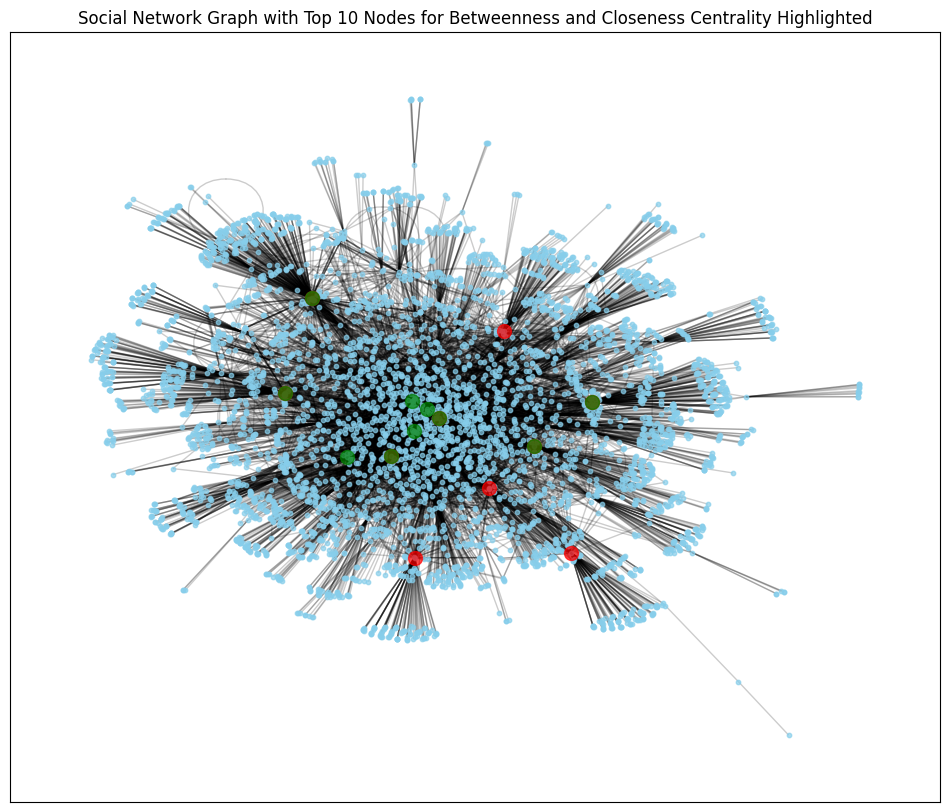

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Get the top 10 nodes for each centrality measure
top_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]
top_closeness_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:10]

# Print centrality measures for each node
for username in top_betweenness_nodes:
    betweenness = betweenness_centrality[username]
    closeness = closeness_centrality[username]
    print(f"{username}: Betweenness Centrality = {betweenness}, Closeness Centrality = {closeness}")

# Plot the graph with top 10 nodes for betweenness and closeness centrality highlighted
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 10))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Highlight top 10 nodes for betweenness centrality in red
nx.draw_networkx_nodes(G, pos, nodelist=top_betweenness_nodes, node_size=100, node_color='red', alpha=0.7)

# Highlight top 10 nodes for closeness centrality in green
nx.draw_networkx_nodes(G, pos, nodelist=top_closeness_nodes, node_size=100, node_color='green', alpha=0.7)

#nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Social Network Graph with Top 10 Nodes for Betweenness and Closeness Centrality Highlighted')
plt.show()

### **Community detection using Louvain Modularity**

Community detection is a fundamental step in the analysis of complex networks, and the Louvain algorithm provides an effective means of achieving this. By assigning nodes to communities, we gain insights into the underlying structure of the graph, uncovering groups of nodes that share similar patterns of connectivity.

The 'community' attribute assigned to each node in the graph can now be used for further analysis, such as exploring the characteristics of each community or understanding how information flows within and between these communities.

In [ ]:
# Perform community detection using Louvain Modularity
partition = community_louvain.best_partition(G)

for username, community_id in partition.items():
    G.nodes[username]['community'] = community_id

### Community visualization

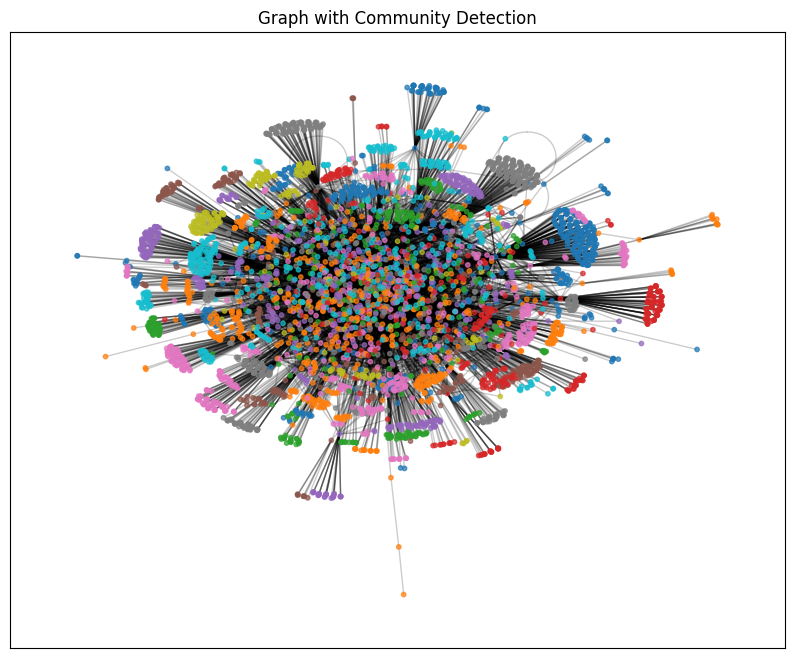

In [ ]:
pos = nx.spring_layout(G)
colors = [partition[username] for username in G.nodes]
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=colors, cmap=plt.cm.tab10, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title('Graph with Community Detection')
plt.show()

### Community Sizes Distribution

#### **Community Metrics**

In [ ]:
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(f"Assortativity (Degree): {degree_assortativity}")

Assortativity (Degree): -0.33996862327884986


This value represents the degree assortativity of the graph. The assortativity coefficient measures the tendency of nodes with similar degrees to be connected. A negative value, as seen here (-0.2873), indicates a disassortative mixing, meaning that nodes with different degrees are more likely to be connected to each other. In this specific case, nodes with high degrees are more likely to be connected to nodes with low degrees and vice versa, contributing to the overall disassortative nature of the graph.

### **Communities analysis**

In [ ]:
c= nx.community.greedy_modularity_communities(G)
# size of communities
community_sizes = [len(community) for community in c]
# Print the sizes of the communities
for i, size in enumerate(community_sizes, 1):
  print(f"Community {i}: Size {size}")

Community 1: Size 689
Community 2: Size 640
Community 3: Size 518
Community 4: Size 211
Community 5: Size 206
Community 6: Size 189
Community 7: Size 167
Community 8: Size 145
Community 9: Size 144
Community 10: Size 142
Community 11: Size 130
Community 12: Size 120
Community 13: Size 120
Community 14: Size 112
Community 15: Size 111
Community 16: Size 111
Community 17: Size 108
Community 18: Size 106
Community 19: Size 105
Community 20: Size 93
Community 21: Size 91
Community 22: Size 86
Community 23: Size 79
Community 24: Size 77
Community 25: Size 76
Community 26: Size 71
Community 27: Size 51
Community 28: Size 35
Community 29: Size 11


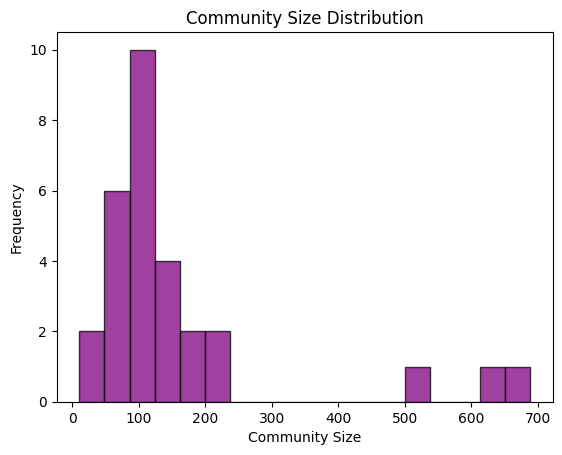

In [ ]:
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)

# Calculate community sizes
community_sizes = [len(community) for community in communities]

# Plot community size distribution
plt.hist(community_sizes, bins='auto', alpha=0.75, color='purple', edgecolor='black')
plt.title("Community Size Distribution")
plt.xlabel("Community Size")
plt.ylabel("Frequency")
plt.show()

In [ ]:
modularity = nx.community.modularity(G, c)

print(f"Modularity: {modularity}")

Modularity: 0.5990571647329075


This value represents the modularity of the graph, a measure that assesses the quality of the division of nodes into communities. Modularity ranges from -1 to 1, where higher values indicate a better division of the network into distinct communities. In this case, the modularity value is 0.6585, suggesting a significant and well-defined community structure within the graph. The positive value indicates that the division of nodes into communities is notably better than what would be expected by random chance.

### Merging Communities Analysis for further analysis

To enhance our capacity for nuanced analysis of comment content within each community, we have enriched each comment entry with its respective community identifier. This augmentation empowers us to delve deeply into the themes and discussions unique to individual communities, offering valuable insights into the distinct topics and prevalent content within each community.

In [ ]:
l=[]
i=0
for community in c:
  for node in community:
    l.append([node,i])
  i+=1
dfcommunity= pd.DataFrame(l,columns=['node','community'])

In [ ]:
fc_path = '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/content_comments_final_2.csv'
fc = pd.read_csv(fc_path)

In [ ]:
first_comments = pd.DataFrame(fc, columns=['comment','author'])

In [ ]:
first_comments.head()

,comment,author
0,"I'm a bot, *bleep*, *bloop*. Someone has linke...",TotesMessenger
1,Il [documento del Senato](http://www.senato.it...,WatersJhon
2,"I'm a bot, *bleep*, *bloop*. Someone has linke...",TotesMessenger
3,wow,Garnet9l
4,\> Così ha scritto Naomi Schaefer Riley sul **...,leaningtoweravenger


In [ ]:
merged_df = pd.merge(dfcommunity, first_comments, left_on='node', right_on='author', how='inner')

In [ ]:
merged_df.head()

,node,community,comment,author
0,SnooWords259,0,"Lui probabilmente verrà condannato, loro sono ...",SnooWords259
1,stiveoh23,0,"Se era bianco lo avrebbero pestato uguale, \nC...",stiveoh23
2,wearsAtrenchcoat,0,"Onestamente, C'importa una sega",wearsAtrenchcoat
3,throwaway666879,0,Anch’io li odio i bimbiminnchia/maranza/carica...,throwaway666879
4,Alixiapix,0,Sono sicura che tantissimi hanno saputo della ...,Alixiapix


## **Content analysis**


### **Some exploratory analysis**

In [ ]:
## Posts with more comments on the murder case
popular_comments = df_comment_omicidio.dropna().drop_duplicates('title').sort_values(by=['num_comments'], ascending=False).query('response == False').head(10)[["title", "num_comments", "upvote_ratio", "score"]]
popular_comments = popular_comments.rename(columns={"title" : "Post Title", "num_comments" : "Num. Comments", "upvote_ratio" : "Upvote Ratio"})

popular_comments.style \
  .set_caption("Posts on the murder case with more comments") \
  .format(precision=2, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .set_properties(**{'text-align': 'center', 'font-size':'17px', 'font-family':'italics'}) \
  .set_properties(color="black", border="2px solid black") \
  .hide(axis="index") \
  .set_table_styles([
                            {
                                "selector":"th",
                                "props": [("background-color", "#0c844a"), ("color", "white"), ('font-family', 'italics'),
                                          ("border", "2px solid black"), ("text-align", "center"), ("font-size", "17px")
                                          ]
                            },
                            {
                                "selector":"caption",
                                "props": [("text-align", "center"), ("font-size", "150%"), #("font-weight", 'bold'),
                                          ('font-family', 'italics')
                                        ]
                            }
                        ])

POST TITLE,NUM. COMMENTS,UPVOTE RATIO,SCORE
"Uomini, non vi siete rotti le palle di tutti i post contro di voi?",801,"0,62",245
Ho visto troppi post sulla Giulia Cecchettin,688,"0,82",592
È un covo di incel,651,"0,64",256
"Filippo Turetta arrestato in Germania, il 22enne ha ucciso Giulia Cecchettin",383,"0,94",189
Non c'è nulla di male ad istigare all'odio verso tutti gli uomini,337,"0,73",162
"Accoltellata dal marito per aver difeso la memoria di Giulia, a voi i commenti",307,"0,66",117
"“Gli uomini devono fare mea culpa, anche chi non ha mai fatto nulla […]”",287,"0,75",154
Colpa del patriarcato o malattia mentale?,209,"0,72",98
"""Mi è scattato quacosa in testa""Filippo turetta",183,"0,76",83
"L'Italia e gli omicidi, qualche dat",172,"0,95",581


In [ ]:
## Posts with more comments on related topics
popular_comments1 = df_comment_parole.dropna().drop_duplicates('title').sort_values(by=['num_comments'], ascending=False).query('response == False').head(10)[["title", "num_comments", "upvote_ratio", "score"]]
popular_comments1 = popular_comments1.rename(columns={"title" : "Post Title", "num_comments" : "Num. Comments", "upvote_ratio" : "Upvote Ratio"})

popular_comments1.style \
  .set_caption("Posts on topics related to Feminicide with more comments") \
  .format(precision=2, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .set_properties(**{'text-align': 'center', 'font-size':'17px', 'font-family':'italics'}) \
  .set_properties(color="black", border="2px solid black") \
  .hide(axis="index") \
  .set_table_styles([
                            {
                                "selector":"th",
                                "props": [("background-color", "#0c2c84"), ("color", "white"), ('font-family', 'italics'),
                                          ("border", "2px solid black"), ("text-align", "center"), ("font-size", "17px")
                                          ]
                            },
                            {
                                "selector":"caption",
                                "props": [("text-align", "center"), ("font-size", "150%"), #("font-weight", 'bold'),
                                          ('font-family', 'italics')
                                        ]
                            }
                        ])

POST TITLE,NUM. COMMENTS,UPVOTE RATIO,SCORE
"39 FEMMINICIDI, NON 105",1.087,"0,74",901
Imbecillità e legittima difesa,1.060,"0,76",510
Ho visto troppi post sulla Giulia Cecchettin,688,"0,82",593
Discoteche che fanno prezzi diversi e femminismo,683,"0,59",51
È un covo di incel,651,"0,64",257
Cosa ne pensate di Cecchettin E. e della sua nomina a Persona dell’Anno?,643,"0,70",276
Essere uomini è difficile in italia.,618,"0,54",11
"(serio) Meloni pensaci tu! Lo stupro di Roma, il 22enne: ""Io, trascinato e violentato nell'androne di un palazzo""",513,"0,63",102
"Ho visto Barbie, e non ho capito perchè molti uomini si sono offesi",508,"0,85",352
Colpa del patriarcato e dello Stato,443,"0,60",81


### **Femicide analysis by time and space**


In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, Point

In [ ]:
file1_path = '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/Elenco-comuni-italiani.csv'
file1 = pd.read_csv(file1_path, encoding_errors='replace', sep=';')
#file1 = pd.read_csv('Elenco-comuni-italiani.csv', encoding_errors='replace', sep=';')
file1 = pd.DataFrame(file1)[['Denominazione in italiano','Denominazione regione']]
print(file1.shape)
file1.head(3)

(7964, 2)


,Denominazione in italiano,Denominazione regione
0,Agli�,Piemonte
1,Airasca,Piemonte
2,Ala di Stura,Piemonte


In [ ]:
file2_path = '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/list_of_feminicides.csv'
file2 = pd.read_csv(file2_path, encoding_errors='replace', sep=';')
#file2 = pd.read_csv('list_of_feminicides.csv', encoding_errors='replace', sep=';')
file2 = pd.DataFrame(file2)
print(file2.shape)
file2.head(3)

(43, 3)


,Name,City,Date
0,Giulia Donato,Pontedecimo di Genova,04/01/23
1,Martina Scialdone,Tuscolano di Roma,13/01/23
2,Oriana Brunelli,Bellaria Igea Marina,14/01/23


In [ ]:
df_feminicides = file2.merge(file1, how ='left', left_on='City', right_on='Denominazione in italiano')
df_feminicides = df_feminicides.drop('Denominazione in italiano', axis = 1)

In [ ]:
df_feminicides.at[0, 'Denominazione regione'] = 'Luguria'
df_feminicides.at[1, 'Denominazione regione'] = 'Lazio'
df_feminicides.at[2, 'Denominazione regione'] = 'Emilia-Romagna'
df_feminicides.at[9, 'Denominazione regione'] = 'Liguria'
df_feminicides.at[17, 'Denominazione regione'] = 'Lazio'
df_feminicides.at[22, 'Denominazione regione'] = 'Lazio'
df_feminicides.at[24, 'Denominazione regione'] = 'Campania'
df_feminicides.at[42, 'Denominazione regione'] = 'Veneto'

In [ ]:
df_feminicides = df_feminicides.replace('Trentino-Alto Adige/S�dtirol', 'Trentino-Alto Adige/Südtirol')
df_feminicides = df_feminicides.replace('Trentino-Alto Adige/S�dtirol', "Valle d'Aosta/Vallée d'Aoste")
df_feminicides = df_feminicides.replace('Maria Febronia Butt�', "Maria Febronia Buttò")

In [ ]:
df_feminicides = df_feminicides.rename(columns={'Denominazione regione': 'Region'})

In [ ]:
counts = pd.DataFrame(df_feminicides.groupby(['Region'], group_keys=False)['Region'].count())
counts['count'] = counts.Region
counts = counts.drop('Region', axis = 1)
counts.Region = counts.index
counts = counts.reset_index()

<ipython-input-64-e9aadc2e39a6>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  counts.Region = counts.index


In [ ]:
#Download a geojson of the region geometries
gdf = gpd.read_file(filename=r'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_municipalities.geojson')
gdf = gdf.dissolve(by='reg_name') #The geojson is to detailed, dissolve boundaries by reg_name attribute
gdf = gdf.reset_index()

In [ ]:
gdf = pd.merge(left=gdf, right=counts, how='left', left_on='reg_name', right_on='Region')

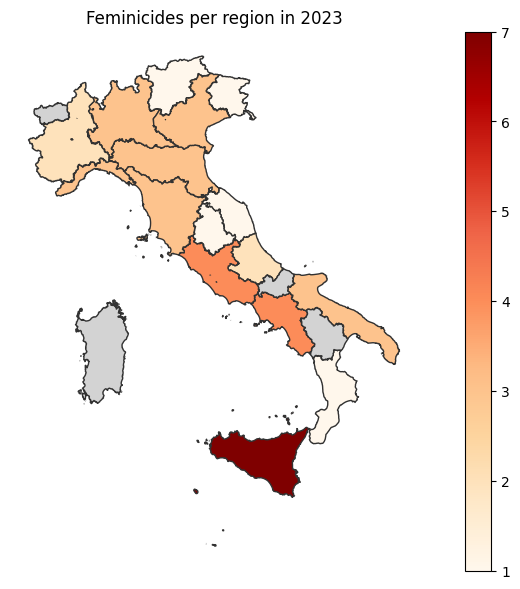

In [ ]:
ax = gdf.plot(
    column="count",
    legend=True,
    figsize=(12, 7),
    cmap='OrRd',
    edgecolor='#323232',
    missing_kwds={'color': 'lightgrey'})

ax.set_axis_off()
ax.set_title("Feminicides per region in 2023")
plt.show()

In [ ]:
# df_feminicides['Level'] = [np.random.randint(-10,-1) if (i%2)==0 else np.random.randint(1,10) for i in range(len(df_feminicides))]

In [ ]:
levels = [
    -6, 9, -9, 8, -6, 4, -4, 1, -2, 3, -8, 2, -7, 4, -4, 1, -2, 3, -10, 6,
    -7, 5, -5, 7, -8, 4, -2, 8, -6, 5, -10, 9, -8, 1, -9, 3, -5, 1, -7, 7,
    -10, 2, -8
]

In [ ]:
df_feminicides['Level'] = levels

In [ ]:
# df_feminicides.at[14, 'Level'] = -4
# df_feminicides.at[20, 'Level'] = -7
# df_feminicides.at[28, 'Level'] = -6
# df_feminicides.at[30, 'Level'] = -10
# df_feminicides.at[34, 'Level'] = -9
# df_feminicides.at[38, 'Level'] = -7
# df_feminicides.at[42, 'Level'] = -8

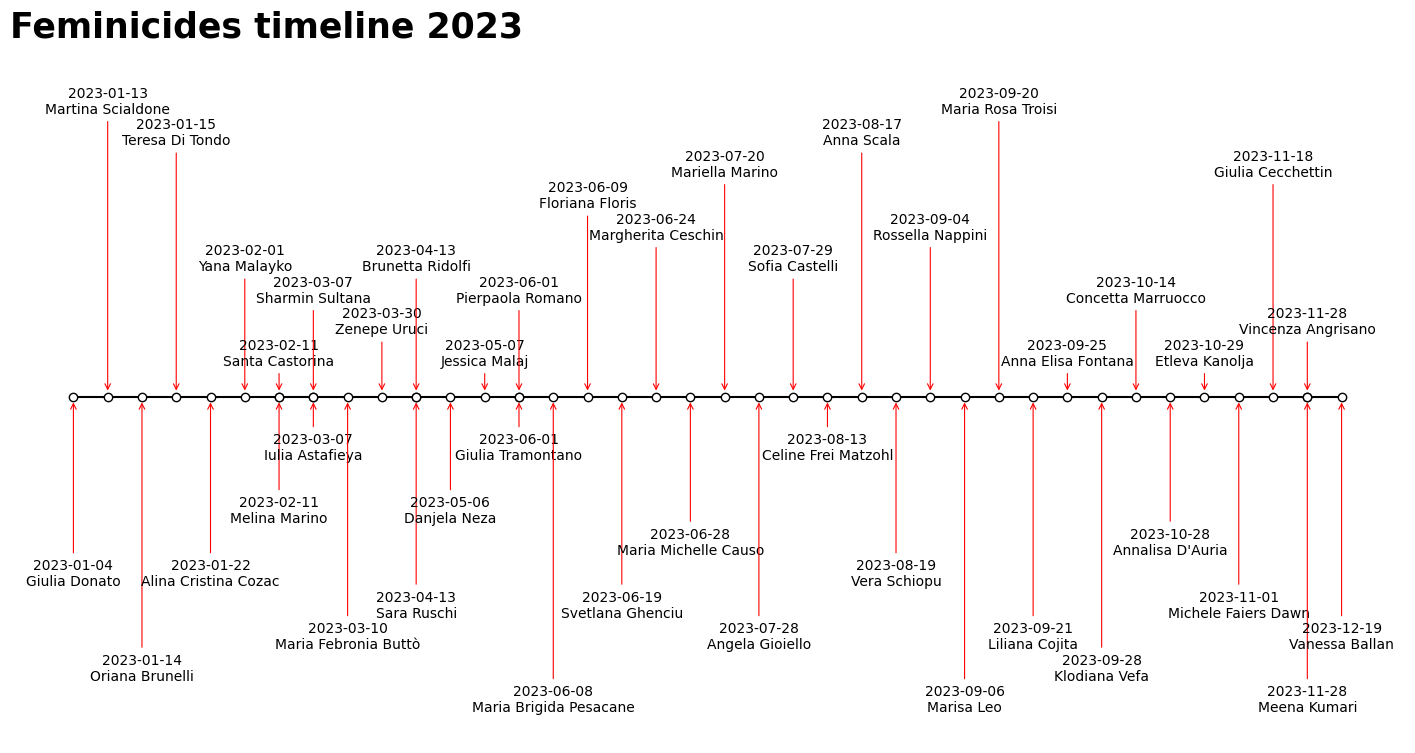

In [ ]:
fig, ax = plt.subplots(figsize=(18,9))

ax.plot(df_feminicides.Date, [0,]* len(df_feminicides), "-o", color="black", markerfacecolor="white");

# ax.set_xticks(pd.date_range("2007-1-1", "2023-1-1", freq="ys"), range(2007, 2024));
ax.set_ylim(-11,11);

for idx in range(len(df_feminicides)):
    dt, name, level = df_feminicides["Date"][idx], df_feminicides["Name"][idx], df_feminicides["Level"][idx]
    dt_str = str(datetime.strptime(dt, '%d/%m/%y').date())
    ax.annotate(dt_str + "\n" + name, xy=(dt, 0.1 if level>0 else -0.1),xytext=(dt, level),
                arrowprops=dict(arrowstyle="->",color="red", linewidth=0.8),
                ha="center"
               );

ax.spines[["left", "top", "right", "bottom"]].set_visible(False);
ax.spines[["bottom"]].set_position(("axes", 0.5));
ax.yaxis.set_visible(False);
ax.xaxis.set_visible(False);
ax.set_title("Feminicides timeline 2023", pad=10, loc="left", fontsize=25, fontweight="bold");

### **Sentiment analysis**
**Sentiment analysis** applied to social media involves using natural language processing and machine learning techniques to automatically detect, extract, and analyze opinions, attitudes, or emotions expressed in social media content. It aims to understand the overall sentiment—positive, negative, or neutral—towards specific topics, products, events, or individuals within the posts, comments, or other user-generated content on social media platforms.

#### **Preprocessing steps**

In [ ]:
def remove_special_characters(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

In [ ]:
def remove_stopwords(text):
    return ' '.join([word for word in text if word.lower() not in stop])

In [ ]:
def lemmaSentence(token_words):
    lemma_text=[]
    for word in token_words:
        lemma_text.append(wordnet_lemmatizer.lemmatize(word))
    return lemma_text

In [ ]:
def remove_urls(text):
    return url_pattern.sub('', text)

In [ ]:
def remove_long(texts):
    texts = [t for t in texts if len(t) < 20]
    return texts

In [ ]:
# function that carries out sentiment analysis
def analyze_sentiment(comment):
    sentiment_score = sia.polarity_scores(comment)['compound']
    if sentiment_score >= 0.1:
        return 'Positive'
    elif sentiment_score <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
def analyze_sentiment_bert(comment):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits)
    if predicted_class == 0:
        return 'Very negative'
    elif predicted_class == 1:
        return 'Negative'
    elif predicted_class == 2:
        return 'Neutral'
    elif predicted_class == 3:
        return 'Positive'
    elif predicted_class == 4:
        return 'Very positive'

In [ ]:
def get_top_n_grams(text, n, top_n):
    words = text.split()
    n_grams = list(ngrams(words, n))
    n_grams_counts = Counter(n_grams)
    top_n_grams = n_grams_counts.most_common(top_n)
    return top_n_grams

In [ ]:
# url_pattern = re.compile(r'https?://\S+|www\.\S+')
# df_comment_parole['comment_preprocessed'] =df_comment_parole['comments'].apply(lambda x: remove_urls(x))
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].str.replace('\n',' ')
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: remove_special_characters(x))
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].str.lower()
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: remove_stopwords(x))
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].str.strip()
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: word_tokenize(x))
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: remove_long(x))
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: lemmaSentence(x))

In [ ]:
df_comment_parole['comments'] = df_comment_parole['comments'].str.replace(r'This post was mass deleted and anonymized with \[Redact\]\(https://redact\.dev\)', '')
df_comment_parole['comments'] = df_comment_parole['comments'].str.replace(r'this post was mass deleted', '')
df_comment_parole['comments'] = df_comment_parole['comments'].str.strip()

<ipython-input-25-98742a3851d6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_comment_parole['comments'] = df_comment_parole['comments'].str.replace(r'This post was mass deleted and anonymized with \[Redact\]\(https://redact\.dev\)', '')


In [ ]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
df_comment_parole['comment_preprocessed'] = df_comment_parole['comments'].apply(lambda x: word_tokenize(x))
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: remove_stopwords(x))
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: remove_urls(x))
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].str.replace('\n',' ')
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].apply(lambda x: remove_special_characters(x))
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].str.lower()
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].str.strip()
df_comment_parole['token'] = df_comment_parole['comment_preprocessed'].apply(lambda x: x.split())

In [ ]:
# df_comment_parole['comment_preprocessed']  = df_comment_parole['comment_preprocessed'] .apply(lambda x: ' '.join(x))
# df_comment_parole

In [ ]:
df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].fillna('')
## actually perfor sentiment analysis
#df_comment_parole['sentiment'] = df_comment_parole['comment_preprocessed'].apply(analyze_sentiment_bert)

In [ ]:
df_comment_parole.to_csv("sentiment analysis.csv", index=False)

In [ ]:
sentiment_path = "/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/sentiment analysis.csv"
df_comment_parole = pd.read_csv(sentiment_path)

#### **Sentiment results**

In [ ]:
neutral_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Neutral'].reset_index(drop=True)
negative_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Negative'].reset_index(drop=True)
positive_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Positive'].reset_index(drop=True)
very_positive_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Very positive'].reset_index(drop=True)
very_negative_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Very negative'].reset_index(drop=True)
print("Neutral comments:",len(neutral_comments))
print(neutral_comments["comments"][0])
print("Negative comments:",len(negative_comments))
print(negative_comments["comments"][0])
print("Positive comments:",len(positive_comments))
print(positive_comments["comments"][0])
print("Very Negative comments:",len(very_negative_comments))
print(very_negative_comments["comments"][0])
print("Very Positive comments:",len(very_positive_comments))
print(very_positive_comments["comments"][0])

Neutral comments: 2145
\> Così ha scritto Naomi Schaefer Riley sul **New York Post**

Il New York Post è un quotidiano buono solo per le news locali e quelle di sport, non lo reputerei una fonte di grande importanza per argomenti di questo genere.

PS: da non confondersi col The Washington Post che è un signor giornale!
Negative comments: 1289
Non so quanto possa esserti utile in questo contesto, ma leggendo il post mi è venuto in mente il libricino "rime di rabbia" di Bruno Tognolini. Sono piccole, piccole poesie ed è un libro che si legge in pochissimo; magari qualche rima farà al caso tuo!
Positive comments: 585
Non è la prima volta che sento raccontare storie del genere. C'è chi se ne approfitta, come nel tuo caso.
Very Negative comments: 8680
Ammazza che bel post che hai scritto! Questa faccenda ha fatto uscire tutte le cose che vengono sussurrate, ma nessuno ha mai avuto il coraggio di scrivere sui quotidiani.

La Choaoqui fa capire quello che bisogna fare per fare carriera davve

In [ ]:
sentiments = ['Very Negative', 'Neutral','Very Positive','Negative','Positive']
count = [len(very_negative_comments),len(neutral_comments),len(very_positive_comments),len(negative_comments),len(positive_comments)]
fig = go.Figure(go.Funnelarea(
    text =sentiments,
    values = count,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"},
    showlegend=False
    ))
fig.show()

In [ ]:
# df_comment_parole['comment_preprocessed'] = df_comment_parole['comment_preprocessed'].fillna('')
# df_comment_parole['sentiment'] = df_comment_parole['comment_preprocessed'].apply(analyze_sentiment)

In [ ]:
df_comment_parole['sentiment'].replace('Very positive', 'Positive', inplace=True)
df_comment_parole['sentiment'].replace('Very negative', 'Negative', inplace=True)

In [ ]:
# neutral_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Neutral'].reset_index(drop=True)
# negative_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Negative'].reset_index(drop=True)
# positive_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Positive'].reset_index(drop=True)
# print("EXAMPLE OF COMMENTS")
# print("Neutral comments:",len(neutral_comments))
# print(neutral_comments["comments"][100])
# print("Negative comments:",len(negative_comments))
# print(negative_comments["comments"][100])
# print("Positive comments:",len(positive_comments))
# print(positive_comments["comments"][100])

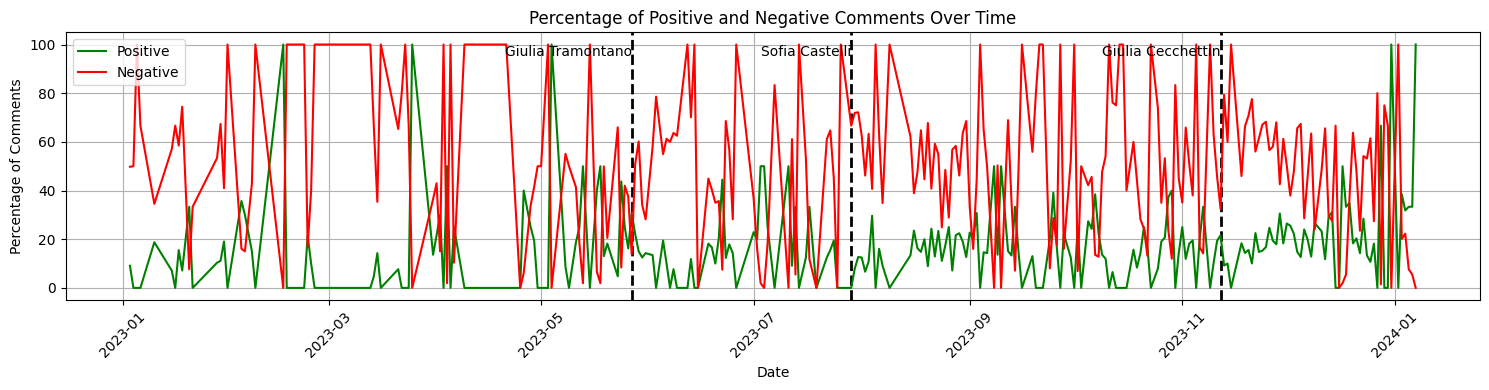

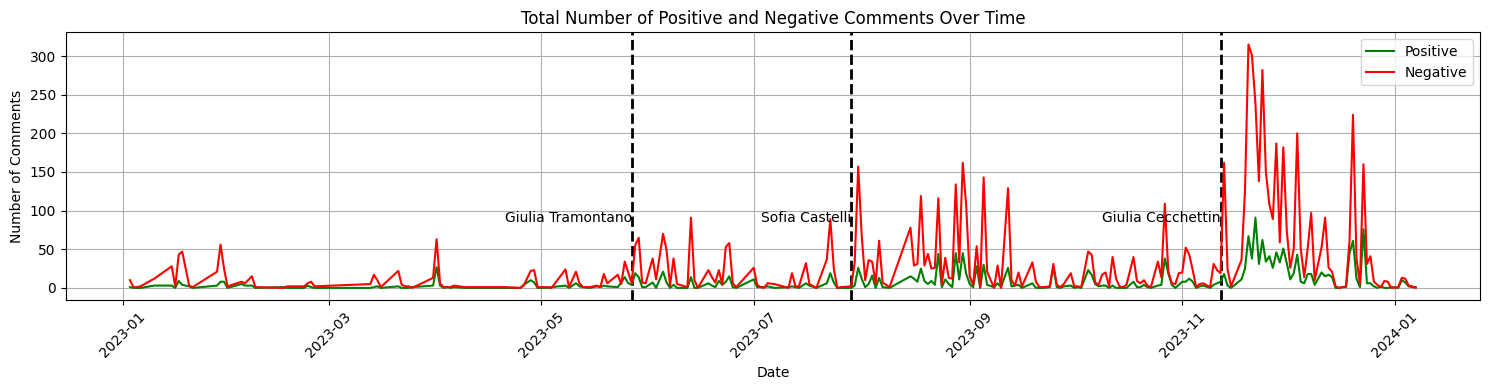

In [ ]:
df_comment_parole['created_utc'] = pd.to_datetime(df_comment_parole['created_utc'])
df_after_2022 = df_comment_parole[df_comment_parole['created_utc'].dt.year > 2022]
comments_by_date = df_after_2022.groupby([df_after_2022['created_utc'].dt.date, 'sentiment']).size().unstack(fill_value=0)
comments_by_date['positive_percentage'] = comments_by_date['Positive'] / comments_by_date.sum(axis=1) * 100
comments_by_date['negative_percentage'] = comments_by_date['Negative'] / comments_by_date.sum(axis=1) * 100

plt.figure(figsize=(15, 4))

murder_date = pd.to_datetime('2023-11-12')
plt.axvline(murder_date, color='black', linestyle='--', linewidth=2)
plt.text(x=murder_date, y=100, s='Giulia Cecchettin', color='black', ha='right', va='top', rotation='horizontal')

murder_date2 = pd.to_datetime('2023-07-29')
plt.axvline(murder_date2, color='black', linestyle='--', linewidth=2)
plt.text(x=murder_date2, y=100, s='Sofia Castelli', color='black', ha='right', va='top', rotation='horizontal')

murder_date3 = pd.to_datetime('2023-05-27')
plt.axvline(murder_date3, color='black', linestyle='--', linewidth=2)
plt.text(x=murder_date3, y=100, s='Giulia Tramontano', color='black', ha='right', va='top', rotation='horizontal')

plt.plot(comments_by_date.index, comments_by_date['positive_percentage'], color='green', label='Positive')
plt.plot(comments_by_date.index, comments_by_date['negative_percentage'], color='red', label='Negative')
plt.title('Percentage of Positive and Negative Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Comments')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 4))
murder_date = pd.to_datetime('2023-11-12')
plt.axvline(murder_date, color='black', linestyle='--', linewidth=2)
plt.text(x=murder_date, y=100, s='Giulia Cecchettin', color='black', ha='right', va='top', rotation='horizontal')

murder_date2 = pd.to_datetime('2023-07-29')
plt.axvline(murder_date2, color='black', linestyle='--', linewidth=2)
plt.text(x=murder_date2, y=100, s='Sofia Castelli', color='black', ha='right', va='top', rotation='horizontal')

murder_date3 = pd.to_datetime('2023-05-27')
plt.axvline(murder_date3, color='black', linestyle='--', linewidth=2)
plt.text(x=murder_date3, y=100, s='Giulia Tramontano', color='black', ha='right', va='top', rotation='horizontal')



plt.plot(comments_by_date.index, comments_by_date['Positive'], color='green', label='Positive')
plt.plot(comments_by_date.index, comments_by_date['Negative'], color='red', label='Negative')
plt.title('Total Number of Positive and Negative Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

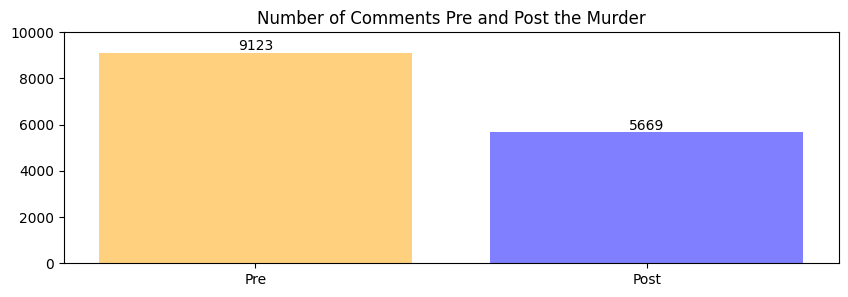

In [ ]:
pre_post_data = pd.DataFrame(df_comment_parole.groupby('pre_post', group_keys=False)['pre_post'].count())
pre_post_data = pre_post_data.sort_index(axis=0, ascending=False)

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 3))
ax1.bar(pre_post_data.index, pre_post_data.pre_post, align='center', alpha=0.5, color=['orange', 'blue'])
ax1.set_title('Number of Comments Pre and Post the Murder', fontsize=12)
ax1.set_ylim(0,10000)

for i in range(len(pre_post_data.pre_post)):
        ax1.text(i, pre_post_data.pre_post[i]+100, pre_post_data.pre_post[i], ha = 'center')

plt.show()

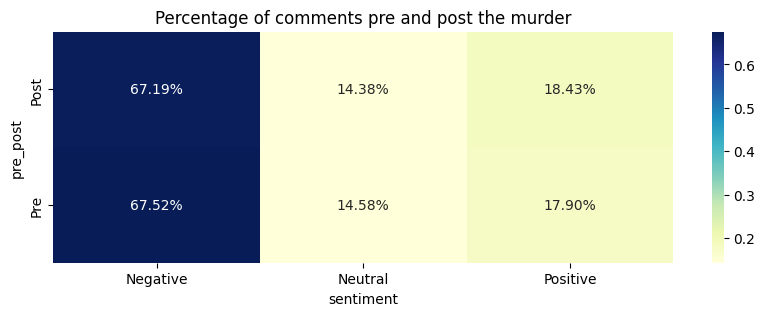

In [ ]:
data_evento=pd.to_datetime('2023-11-12')
df_comment_parole['created_utc'] = pd.to_datetime(df_comment_parole['created_utc'])
df_comment_parole['pre_post'] = df_comment_parole['created_utc'].apply(lambda x: 'Pre' if x < data_evento else 'Post')
total_comments_by_period = df_comment_parole.groupby('pre_post')['sentiment'].count()

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]})
# sns.countplot(x=pre_post_data.index, hue=pre_post_data.values, data=pre_post_data, ax=ax1, palette='Set2')
# ax1.set_title('Number of Comments Pre and Post the Murder', fontsize=16)
# ax1.set_ylabel('Number of Comments', fontsize=14)
# ax1.legend().set_visible(False)
# for p in ax1.patches:
#     ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

fig, (ax2) = plt.subplots(1, 1, figsize=(10, 3))
heatmap_data_percentages = (df_comment_parole.groupby(['pre_post', 'sentiment']).size() / total_comments_by_period).unstack().fillna(0)
sns.heatmap(heatmap_data_percentages, cmap="YlGnBu", annot=True, fmt='.2%', ax=ax2,)
ax2.set_title('Percentage of comments pre and post the murder')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
# import matplotlib.ticker as plticker
# import matplotlib.dates as mdates

# figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8))

# figure.tight_layout(pad=5.0)

# ax1.plot(comments_by_date.index, comments_by_date['positive_percentage'], color='yellowgreen', label='Positive', linewidth=1)
# ax1.plot(comments_by_date.index, comments_by_date['negative_percentage'], color='red', label='Negative', linewidth=1)
# ax1.set_title('Percentage of Positive and Negative Comments Over Time')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Percentage of Comments')
# ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# # ax1.set_xlim([str(datetime.strptime('01/01/2023', '%d/%m/%y').date()), str(datetime.strptime('31/12/2013', '%d/%m/%y').date())])
# ax1.grid()
# ax1.legend(loc="upper right")


# ax2.plot(comments_by_date.index, comments_by_date['Positive'], color='yellowgreen', label='Positive', linewidth=1)
# ax2.plot(comments_by_date.index, comments_by_date['Negative'], color='red', label='Negative', linewidth=1)
# ax2.set_title('\nTotal Number of Positive and Negative Comments Over Time')
# ax2.set_xlabel('Date')
# ax2.set_ylabel('Number of Comments')
# ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# ax2.grid()
# ax2.legend(loc="upper right")


# for i in range(len(df_feminicides)):
#   murder_date = pd.to_datetime(df_feminicides.Date[i])
#   if df_feminicides.Name[i] == 'Giulia Cecchettin':
#     col = 'orange'
#     width = 1.5
#   else:
#     col = 'dimgrey'
#     width = 1
#   if i % 2 == 0:
#     y_pos = 100
#   else:
#     y_pos = 93
#   ax1.axvline(murder_date, color=col, linestyle='--', linewidth = width)
#   ax1.text(x = murder_date, y=y_pos, s=i, color='black', ha='right', va='top', rotation='horizontal',fontsize=8)
#   ax2.axvline(murder_date, color=col, linestyle='--', linewidth = width)
#   ax2.text(x = murder_date, y=y_pos, s=i, color='black', ha='right', va='top', rotation='horizontal',fontsize=8)


In [ ]:
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comments'].apply(lambda x: remove_urls(x))
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].str.replace('\n',' ')
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: remove_special_characters(x))
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].str.lower()
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: remove_stopwords(x))
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].str.strip()
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: word_tokenize(x))
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: remove_long(x))
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: lemmaSentence(x))

In [ ]:
# df_comment_omicidio['comment_preprocessed']  = df_comment_omicidio['comment_preprocessed'] .apply(lambda x: ' '.join(x))
# df_comment_omicidio

In [ ]:
# df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].fillna('')
# df_comment_omicidio['sentiment'] = df_comment_omicidio['comment_preprocessed'].apply(analyze_sentiment)

In [ ]:
negative_comments = df_comment_parole[df_comment_parole['sentiment'] == 'Negative'].reset_index(drop=True)
negative_comments['comment'] = negative_comments['token'].astype(str)
all_comments = ' '.join(negative_comments['comment'].str.lower())
top_trigrams = get_top_n_grams(all_comments, 3, 10)
df_trigrams = pd.DataFrame(top_trigrams)
df_trigrams.columns=['Trigram', 'Count']
df_trigrams.style.background_gradient(cmap='Reds')

,Trigram,Count
0,"(""'qualche',"", ""'anno',"", ""'fa',"")",19
1,"(""'fino',"", ""'prova',"", ""'contraria',"")",16
2,"(""'maschio',"", ""'bianco',"", ""'etero',"")",15
3,"(""'maggior',"", ""'parte',"", ""'persone',"")",14
4,"(""'maggior',"", ""'parte',"", ""'casi',"")",14
5,"(""'cosa',"", ""'vuol',"", ""'dire',"")",14
6,"(""'maggior',"", ""'parte',"", ""'donne',"")",14
7,"(""'qualche',"", ""'giorno',"", ""'fa',"")",14
8,"(""'fare',"", ""'mea',"", ""'culpa',"")",14
9,"(""'frega',"", ""'cazzo',"", ""'nessuno',"")",12


In [ ]:
df_comment_omicidio['comments'] = df_comment_omicidio['comments'].str.replace(r'This post was mass deleted and anonymized with \[Redact\]\(https://redact\.dev\)', '')
df_comment_omicidio['comments'] = df_comment_omicidio['comments'].str.replace(r'this post was mass deleted', '')
df_comment_omicidio['comments'] = df_comment_omicidio['comments'].str.strip()
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comments'].apply(lambda x: word_tokenize(x))
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: remove_stopwords(x))
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: remove_urls(x))
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].str.replace('\n',' ')
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: remove_special_characters(x))
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].str.lower()
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].str.strip()
df_comment_omicidio['token'] = df_comment_omicidio['comment_preprocessed'].apply(lambda x: x.split())

<ipython-input-43-8e352fcec93c>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
df_comment_omicidio['comment_preprocessed'] = df_comment_omicidio['comment_preprocessed'].fillna('')
#df_comment_omicidio['sentiment'] = df_comment_omicidio['comments'].apply(analyze_sentiment_bert)
df_comment_omicidio.to_csv("sentiment analysis omicidio.csv", index=False)

In [ ]:
sentiment_omicidio_path = '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/sentiment analysis omicidio.csv'
df_comment_omicidio = pd.read_csv(sentiment_omicidio_path)

In [ ]:
df_comment_omicidio['sentiment'].replace('Very positive', 'Positive', inplace=True)
df_comment_omicidio['sentiment'].replace('Very negative', 'Negative', inplace=True)

In [ ]:
neutral_comments_omicidio = df_comment_omicidio[df_comment_omicidio['sentiment'] == 'Neutral'].reset_index(drop=True)
negative_comments_omicidio = df_comment_omicidio[df_comment_omicidio['sentiment'] == 'Negative'].reset_index(drop=True)
positive_comments_omicidio = df_comment_omicidio[df_comment_omicidio['sentiment'] == 'Positive'].reset_index(drop=True)
print("Neutral comments:",len(neutral_comments_omicidio))
print(neutral_comments_omicidio["comments"][0])
print("Negative comments:",len(negative_comments_omicidio))
print(negative_comments_omicidio["comments"][0])
print("Positive comments:",len(positive_comments_omicidio))
print(positive_comments_omicidio["comments"][0])


Neutral comments: 395
Ahia
Negative comments: 1176
Fuga d’amore?
Positive comments: 398
E' come leggere un libro appena iniziato conoscendo già il capitolo finale


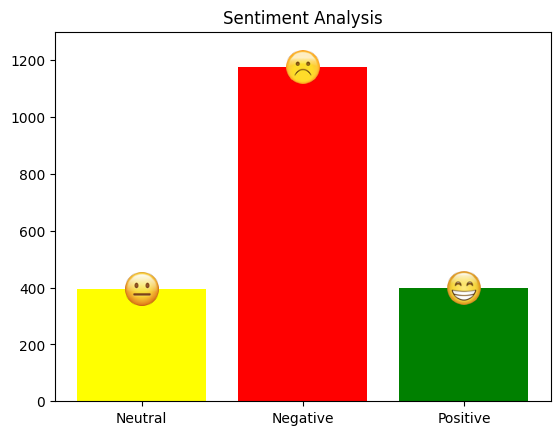

In [ ]:
sentiments = ['Neutral', 'Negative','Positive']
count = [len(neutral_comments_omicidio), len(negative_comments_omicidio),len(positive_comments_omicidio)]
emoji_paths = ['/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/neutral.jpg',
               '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/sad.png',
               '/content/drive/MyDrive/SMA_Cervini_Montalbano_Sabino_ProjectFiles/happy.png']

fig, ax = plt.subplots()

bars = ax.bar(sentiments, count, color=['yellow', 'red','green'])

for bar, emoji_path in zip(bars, emoji_paths):
    emoji = Image.open(emoji_path)
    emoji = emoji.resize((40, 40))
    imagebox = OffsetImage(emoji, zoom=0.6)
    ab = AnnotationBbox(imagebox, (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        boxcoords="data", frameon=False, pad=0.2)
    ax.add_artist(ab)

plt.ylim(0,1300)
plt.title("Sentiment Analysis")
plt.show()

In [ ]:
negative_comments_omicidio['comment'] = negative_comments_omicidio['token'].astype(str)
all_comments = ' '.join(negative_comments_omicidio['comment'].str.lower())
top_trigrams = get_top_n_grams(all_comments, 3, 10)
df_trigrams = pd.DataFrame(top_trigrams)
df_trigrams.columns=['Trigram', 'Count']
df_trigrams.style.background_gradient(cmap='Reds')

,Trigram,Count
0,"(""'fare',"", ""'mea',"", ""'culpa',"")",11
1,"(""'vero',"", ""'ogni',"", ""'uomo',"")",7
2,"(""'ogni',"", ""'uomo',"", ""'possibile',"")",7
3,"(""'uomo',"", ""'possibile',"", ""'assassino',"")",7
4,"(""'possibile',"", ""'assassino',"", ""'s',"")",7
5,"(""'assassino',"", ""'s',"", ""'dispiace',"")",7
6,"(""'s',"", ""'dispiace',"", ""'tecnicamente',"")",7
7,"(""'dispiace',"", ""'tecnicamente',"", ""'cos',"")",7
8,"(""'qualche',"", ""'giorno',"", ""'fa',"")",6
9,"(""'tutta',"", ""'lerba',"", ""'fascio',"")",6


### **Topics in communities**

We're blending two powerful methods, network analysis and content analysis, for a comprehensive exploration. Our first step involves connecting comments to community IDs after detecting these communities. By gathering comments based on their community, we create bundles of conversations unique to each group.

Now, we're diving into the words used most frequently in each community, aiming to compare them. This helps us uncover the distinct language styles and hot topics that shape these groups. Our approach goes beyond just understanding the structure of the network; it delves into the actual discussions, offering a holistic view of how online communities connect and communicate.

In [ ]:
!python -m spacy download it_core_news_sm

import spacy
nlp = spacy.load("it_core_news_sm")

2024-01-12 11:27:17.065907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 11:27:17.066032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 11:27:17.069322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 11:27:18.692721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [ ]:
grouped_df = merged_df.groupby('community')['comment'].agg(lambda x: ' '.join(x.dropna())).reset_index()

In [ ]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop])

In [ ]:
grouped_df

,community,comment
0,0,"Lui probabilmente verrà condannato, loro sono ..."
1,1,Uno schiaffo è violenza ecco il perchè dei dat...
2,2,No sono gli spritz a 11€ \n/s Io scriverei un ...
3,3,Andate a leggere sul fatto. Tutto spiegato mol...
4,4,Mi sa che quello confuso sei tu: oggi il termi...
5,5,quello che non è mai chiaro è che la violenza ...
6,6,Non so da altre parti ma nel mio paesino ci so...
7,7,"Dovresti ricontattare il centro, chiedere di u..."
8,8,"Apprezzo l’impegno, ma i’m not reading allat 💀..."
9,9,"""La culla del nuovo Rinascimento"" - cit.\n\nTa..."


In [ ]:
def extract_topics(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

grouped_df['topics'] = grouped_df['comment'].apply(extract_topics)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
# Assuming 'grouped_df' is your DataFrame with communities and comments
# Assuming the column containing comments is named 'comment'

# Function to tokenize and count occurrences for a given community
def get_top_tokens_for_community(community_df, top_n=3):
    # Combine all comments in the community
    # Count occurrences
    token_counter = Counter(community_df.iloc[0,2])

    # Get top N tokens
    top_tokens = dict(token_counter.most_common(top_n))

    return top_tokens
top_tokens_dict = {}
# Assuming 'community_sizes' is a list containing community sizes
for community_id in range(0, len(community_sizes) - 1):
    # Filter DataFrame for the current community
    community_df = grouped_df[grouped_df['community'] == community_id]

    # Get top 3 tokens for the community
    top_tokens = get_top_tokens_for_community(community_df, top_n=10)

    top_tokens_dict[f'Community_{community_id}'] = list(top_tokens.keys())

    print(top_tokens)


{'il': 438, 'o': 298, 'potere': 173, 'volere': 159, 'dovere': 155, 'problema': 130, 'donna': 130, 'sapere': 110, 'vedere': 110, 'pensare': 109}
{'il': 1069, 'donna': 655, 'o': 610, 'uomo': 446, 'problema': 413, 'dovere': 353, 'potere': 307, 'volere': 281, 'parlare': 262, 'violenza': 257}
{'il': 527, 'donna': 440, 'o': 343, 'uomo': 207, 'volere': 207, 'dovere': 167, 'pensare': 165, 'problema': 157, 'potere': 154, 'vedere': 148}
{'il': 153, 'donna': 112, 'dovere': 77, 'o': 76, 'uomo': 68, 'violenza': 66, 'parlare': 62, 'problema': 52, 'Italia': 52, 'potere': 47}
{'il': 148, 'o': 121, 'donna': 110, 'dovere': 91, 'volere': 73, 'uomo': 69, 'potere': 66, 'venire': 62, 'pagare': 62, 'andare': 54}
{'donna': 77, 'il': 66, 'o': 47, 'violenza': 42, 'pensare': 36, 'problema': 34, 'uomo': 32, 'parlare': 31, 'genere': 31, 'post': 28}
{'il': 130, 'o': 82, 'donna': 64, 'volere': 48, 'potere': 45, 'ragazza': 43, 'andare': 36, 'ragazzo': 35, 'problema': 33, 'vedere': 33}
{'il': 52, 'donna': 50, 'o': 46,

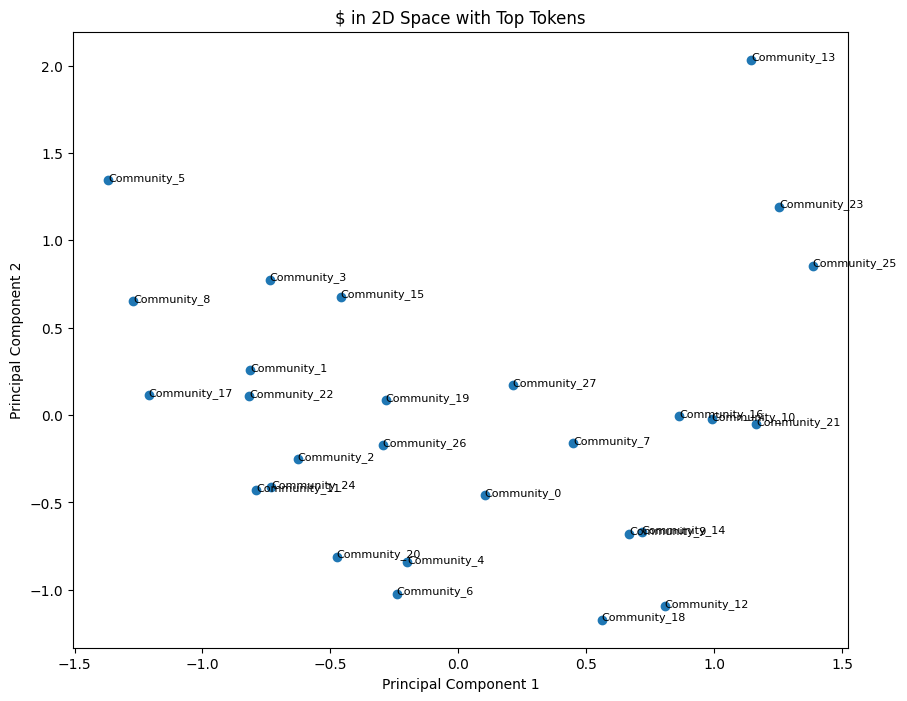

Community Number    Top Tokens
------------------  -----------------------------------------------------------------------------
Community_0         il, o, potere, volere, dovere, problema, donna, sapere, vedere, pensare
Community_1         il, donna, o, uomo, problema, dovere, potere, volere, parlare, violenza
Community_2         il, donna, o, uomo, volere, dovere, pensare, problema, potere, vedere
Community_3         il, donna, dovere, o, uomo, violenza, parlare, problema, Italia, potere
Community_4         il, o, donna, dovere, volere, uomo, potere, venire, pagare, andare
Community_5         donna, il, o, violenza, pensare, problema, uomo, parlare, genere, post
Community_6         il, o, donna, volere, potere, ragazza, andare, ragazzo, problema, vedere
Community_7         il, donna, o, dovere, potere, violenza, volere, situazione, sapere, perché
Community_8         il, donna, o, problema, uomo, femminicidio, potere, post, leggere, genere
Community_9         il, o, potere, dovere, an

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tabulate import tabulate

# Assuming 'top_tokens_dict' contains the top tokens for each community
corpus = [' '.join(tokens) for tokens in top_tokens_dict.values()]

# Create a document-term matrix (DTM)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(corpus)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
result = pca.fit_transform(dtm.toarray())

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])

# Annotate each point with community tokens and top tokens
table_data = []
for i, community_id in enumerate(top_tokens_dict.keys()):
    top_tokens = ', '.join(top_tokens_dict[community_id])
    label = f"{community_id}"
    plt.annotate(label, (result[i, 0], result[i, 1]), fontsize=8)

    # Append data for table
    table_data.append([community_id, top_tokens])

plt.title('$ in 2D Space with Top Tokens')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print the table
headers = ["Community Number", "Top Tokens"]
print(tabulate(table_data, headers=headers))
